# Spectral analysis
In this notebook, we perform the spectral analysis for our paper. 
These are the steps:
- for each imitation
  - calculate the MFCCs
  - take the mean (over time) of each of the lowest 12 MFCCs
- perform PCA on the mean 12 MFCCs
- perform k-means clustering on the space of the first 2 PCs
- visualize the space of the first 2 PCs colored by a) species, b) participants, and c) the clustering result
  

In [1]:
import glob
import h5py
import librosa
import numpy as np
import os
import scipy
import sklearn
import sys
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sys.path.append("..")
import localmodule
np.random.seed(2)

## Load data
The data was originally in .mat files. Here we load the data into numpy arrays. 

In [2]:
data_dir = localmodule.get_data_dir()
participant_paths = glob.glob("../data/imitations_participant*.mat")
participant_paths.sort()
n_participants = len(participant_paths)
n_imitations = 100
imitation_matrix = []
species_matrix = []

for participant_path in tqdm.tqdm(participant_paths):
    imitation_list = []
    species_list = []
    
    with h5py.File(participant_path) as h5_file:
        for i in range(n_imitations):
            imitation_waveform = h5_file['#refs#'][
                h5_file["imitations"]["imitationAudio"][i][0]][0]
            species = int(h5_file['#refs#'][
                h5_file["imitations"]["species"][i][0]][0][0])
            imitation_list.append(imitation_waveform)
            species_list.append(species)
        imitation_matrix.append(imitation_list)
        species_matrix.append(species_list)
imitation_matrix = np.array(imitation_matrix)
species_matrix = np.array(species_matrix)

100%|██████████| 17/17 [00:34<00:00,  6.52s/it]


## Mel-frequency cepstral coefficients
For each imitation, we calculate the mean (across time) of the lowest 12 MFCCs.

**why do we use the same waveform twice? (with slightly different start/stop times?)**

In [3]:
participant_id = 0
imitation_id = 0
hop_length = 512
half_event_length = 4096
sr = 44100
n_events = 2
n_mfcc = 12

# initiate where the mean MFCC values will be stored. 
mfcc_tensor = np.zeros((n_mfcc, n_events, n_participants, n_imitations))

for participant_id in tqdm.tqdm(range(n_participants)):
    for imitation_id in range(n_imitations):
        
        # select the given imitation waveform for the given participant
        imitation_waveform = imitation_matrix[participant_id, imitation_id]

        # calculate the RMS to find the spectrogram frames with the most energy
        rms = np.ravel(librosa.feature.rms(
            imitation_waveform, frame_length=2*hop_length, hop_length=hop_length))
        sorting_indices = rms.argsort(axis=0)[::-1]
        
        for event_id in range(n_events):
            
            # define the start and stop time points for the given event
            event_start = max(0, sorting_indices[event_id] * hop_length - half_event_length)
            event_stop = min(len(imitation_waveform),
                             sorting_indices[event_id] * hop_length + half_event_length)
            event_length = event_stop - event_start
            
            # select waveform, apply a Hann window 
            event_waveform = imitation_waveform[event_start:event_stop] * scipy.signal.hann(event_length)
            #plt.plot(event_waveform)
            
            # MFCCs
            mfcc = librosa.feature.mfcc(y=event_waveform, n_mels=40, n_mfcc=(1+n_mfcc), sr=sr)[1:, :]
            
            # mean MFCC over time
            mfcc_tensor[:, event_id, participant_id, imitation_id] = np.mean(mfcc, axis=1)
        
        #mfcc_mean_tensor = np.mean(mfcc_tensor, axis=1)
            


100%|██████████| 17/17 [00:11<00:00,  1.57it/s]


## Principal component analysis
We used PCA to reduce dimensions from 12 (MFCCs) to 2, to allow for visualization 

In [4]:
# reshape for PCA            
species_tensor = np.tile(species_matrix, (n_events, 1, 1))
mfcc_X = np.reshape(mfcc_tensor, (n_mfcc, n_events*n_participants*n_imitations)).T
mfcc_y = np.ravel(species_tensor) - 1
print(species_tensor.shape, mfcc_X.shape, mfcc_y.shape)

pca_model = sklearn.decomposition.PCA().fit(mfcc_X)
pca_X = pca_model.transform(mfcc_X)

print('Variance explained in first 2 components:',
     pca_model.explained_variance_ratio_[0:2])

(2, 17, 100) (3400, 12) (3400,)
Variance explained in first 2 components: [0.30438207 0.23622944]


## K-means clustering
We used K-means clustering to find the simplest grouping of points into 2 groups

In [5]:
n_clusters = 2
kmeans_model = sklearn.cluster.KMeans(n_clusters=n_clusters).fit(mfcc_X)
kmeans_y = kmeans_model.labels_
print('Number of iterations run:', kmeans_model.n_iter_)

Number of iterations run: 18


## Visualizing the results

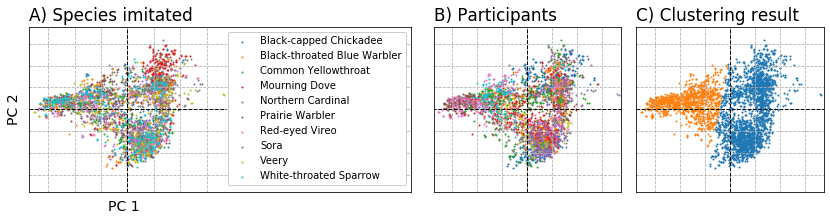

In [6]:
# Visualization of species

species_names_with_sci_names = \
    ['Black-capped chickadee ($Poecile atricapillus$)',
     'Black-throated blue warbler ($Setophaga caerulescens$)',
     'Common yellowthroat ($Geothlypis trichas$)',
     'Mourning dove ($Zenaida macroura$)',
     'Northern cardinal ($Cardinalis cardinalis$)',
     'Prairie warbler ($Setophaga discolor$)',
     'Red-eyed vireo ($Vireo olivaceus$)',
     'Sora ($Porzana carolina$)',
     'Veery ($Catharus fuscescens$)',
     'White-throated sparrow ($Zonotrichia albicollis$)']
plt.rcParams.update({'font.size': 14})
axis_font_size = 14
marker_size = 4
plt.figure(figsize=(12,3.3))
metadata_path = '../data/BirdVox-imitation_metadata.mat'

xmax = 10*(np.max(10+np.abs(pca_X))//10)
n_species = len(np.unique(species_tensor))

with h5py.File(metadata_path) as h5_file:
    species_strings = [
        " ".join([x.capitalize() for x in
        "".join(list(map(chr, h5_file["#refs#"][h5_file["meta"]["species"]["speciesName"][i][0]][:]))).split("_")])
         for i in range(n_species)
    ]

ax1 = plt.subplot(1,2,1)
#ax1.text(0.025, .95, 'A', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top')
plt.title('A) Species imitated', loc='left')
plt.plot([0, 0], [-75, 75], '--', color='k', linewidth=1.0)
plt.plot([-75, 75], [0, 0], '--', color='k', linewidth=1.0)
for species_id in range(n_species): # 3 is kind of in one quadrent
    plt.scatter(
        pca_X[mfcc_y==species_id, 0], pca_X[mfcc_y==species_id, 1],
        marker='.', alpha=1.0, cmap='Set1', 
        label=species_strings[species_id],
        #label=species_names_with_sci_names[species_id],
        s=marker_size)
plt.gca().set_xticks(range(-60, 80, 20))
plt.gca().set_yticks(range(-60, 80, 20))
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.gca().tick_params(length=0)
plt.xlim(-75, 215)
plt.ylim(-75, 75)
plt.legend(framealpha=1, prop={'size':10})#(title="Bird species")
plt.grid(linestyle='--')
plt.xlabel('PC 1', fontsize=axis_font_size)
ax1.xaxis.set_label_coords(.25,-.05)
plt.ylabel('PC 2', fontsize=axis_font_size)

################################################################################
# Visualization of participants
participant_tensor = np.tile(np.arange(0, n_events*n_participants), (n_imitations, 1)).T
participant_y = np.ravel(participant_tensor)
participant_subset = [3, 5, 6] 
participant_complementary_subset = [
    x for x in range(n_participants)
    if x not in participant_subset]

ax2 = plt.subplot(1,4,3)
#ax2.text(0.05, .95, 'B', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='top')
plt.title('B) Participants', loc='left')
plt.plot([0, 0], [-xmax, xmax], '--', color='k', linewidth=1.0)
plt.plot([-xmax, xmax], [0, 0], '--', color='k', linewidth=1.0)

for participant_id in np.arange(n_participants):
    inds1 = participant_y==participant_id
    inds2 = participant_y==participant_id + n_participants
    inds = inds1 + inds2
    plt.scatter(
        pca_X[inds, 0], pca_X[inds, 1],
        marker='.', alpha=1.0, cmap='gray', label=participant_id, s=marker_size)
plt.gca().set_xticks(range(-300, 300, 20))
plt.gca().set_yticks(range(-300, 300, 20))
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.gca().tick_params(length=0)
plt.xlim(-75, 75)
plt.ylim(-75, 75)
plt.grid(linestyle='--')

################################################################################
# Visualization of k-means clusters

labels = ['Mostly hummed', 'Mostly whistled'] # not sure which belongs to which color. Need to ask Natalie

ax3 = plt.subplot(1,4,4)
#ax3.text(0.05, .95, 'C', transform=ax3.transAxes, fontsize=16, fontweight='bold', va='top')
plt.title('C) Clustering result', loc='left')
plt.plot([0, 0], [-75, 75], '--', color='k', linewidth=1.0)
plt.plot([-75, 75], [0, 0], '--', color='k', linewidth=1.0)
for cluster_id in range(n_clusters):
    plt.scatter(
        pca_X[kmeans_y==cluster_id, 0], pca_X[kmeans_y==cluster_id, 1],
        marker='.', alpha=1.0,  s=marker_size)
plt.gca().set_xticks(range(-60, 80, 20))
plt.gca().set_yticks(range(-60, 80, 20))

plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.gca().tick_params(length=0)
plt.xlim(-75, 75)
plt.ylim(-75, 75)
plt.grid(linestyle='--')


################################################################################
plt.tight_layout()
plt.savefig("../figures/vihar2019_pca.png", dpi=750, bbox_inches="tight")

In [7]:
h5_file.close()